# 对未标记数据进行预训练

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow"]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.0
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.3.1
tensorflow version: 2.16.1


- 在本章中，我们实现了基本模型评估的训练循环和代码，以预训练LLM
- 在本章的最后，我们还将OpenAI中公开可用的预训练权重加载到我们的模型中

![Alt text](../../../img/LLM/ch04/pretrain.png)

- 本章涵盖的主题如下所示

![Alt text](../../../img/LLM/ch04/ch04_topic.png)

# 1、评估生成文本模型

- 我们在本节开始时简要回顾一下使用上一章中的代码初始化GPT模型
- 然后，我们讨论LLM的基本评估指标
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集

## 1.1、使用GPT生成文本

- 我们使用上一章中的代码初始化GPT模型

In [3]:
import torch
from ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "embedding_dim": 768,  # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in

- 我们使用0.1以上的dropout, 但现在训练LLM而不dropout是相对常见的
- 现代LLM在nn中也不使用偏置向量. query、key和value矩阵的线性层（与早期的GPT模型不同）,这是通过设置qkv_bias：False来实现的
- 我们只减少了256个token的上下文长度（context_length），以减少训练模型的计算资源需求，而原始的1.24亿参数GPT-2模型使用了1024个token
    - 这是为了让更多的读者能够在他们的笔记本电脑上遵循和执行代码示例
    - 但是，请随时将context_length增加到1024个token（这不需要任何代码更改）
    - 稍后，我们还将从预训练的权重中加载一个上下文长度为1024的模型
- 接下来，我们使用上一章中的generate_text_simple函数来生成文本
- 此外，我们定义了两个函数，text_to_token_ids和token_ids_to_text，用于在本章中使用的token和文本表示之间进行转换

![Alt text](../../../img/LLM/ch04/GPT_process.png)

In [5]:
import tiktoken
from ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 正如我们在上面看到的，该模型不能生成好的文本，因为它还没有经过训练
- 我们如何测量或捕捉数字形式的“好文本”，以在训练中跟踪它？
- 下一小节介绍了用于计算生成输出的损失度量的度量，我们可以使用该度量来衡量训练进度
- 关于微调LLM的下一章还将介绍测量模型质量的其他方法

## 1.2、计算文本生成损失：交叉熵与幻觉

- 假设我们有一个输入张量，其中包含2个训练示例（行）的token ID
- 与输入相对应，目标包含我们希望模型生成的所需token ID
- 请注意，目标是偏移1个位置的输入，如实现数据加载器时所述

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将输入提供给模型，我们获得2个输入示例的logits向量，每个示例由3个标记组成
- 每个标记是对应于词汇表大小的50257维向量
- 应用softmax函数，我们可以将logits张量转化为包含概率得分的同维张量

In [7]:
with torch.no_grad():
    logits = model(inputs)
    
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


- 下图使用了一个非常小的词汇进行说明，概述了我们如何将概率分数转换回文本，我们在上一章结束时对此进行了讨论

![Alt text](../../../img/LLM/ch04/loss_example.png)

- 如前一章所述，我们可以应用argmax函数将概率得分转换为预测的token ID
- 上面的softmax函数为每个token产生了50257维向量；argmax函数返回该向量中最高概率得分的位置，该位置是给定token的预测token ID
- 由于我们有两个输入批次，每个批次有3个token，因此我们获得了2乘3的预测token ID：

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们解码这些token，我们会发现这些token与我们希望模型预测的token（即目标token）截然不同：

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 那是因为模型还没有经过训练
- 为了训练模型，我们需要知道它离正确的预测（目标）有多远

![Alt text](../../../img/LLM/ch04/decode_tokenid.png)

- 与目标索引相对应的token概率如下：

In [13]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Text 1:{target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Text 2:{target_probas_2}")

Text 1:tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2:tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使其接近1的概率
- 在数学优化中，使概率得分的对数最大化比使概率得分本身最大化更容易

In [14]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率

In [15]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是通过优化模型权重，使该平均对数概率尽可能大
- 由于日志的原因，最大可能的值是0，而我们目前距离0很远
- 在深度学习中，最小化负平均对数概率值是一种标准惯例，而不是最大化平均对数概率；在我们的例子中，在深度学习中，我们将最小化10.7722，使其接近0，而不是最大化-10.7722
- -10.7722的负值，即10.7722，在深度学习中也称为交叉熵损失

In [16]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch已经实现了一个执行前面步骤的cross_entropy函数

![Alt text](../../../img/LLM/ch04/cross_entropy.png)

- 在我们应用交叉熵函数之前，让我们检查logits和目标的形状

In [17]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于PyTorch中的cross-entropy_loss函数，我们希望通过在批次维度上组合这些张量来压平这些张量：

In [18]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print(f"Flatten logits:{logits_flat.shape}")
print(f"Flatten targets:{targets_flat.shape}")

Flatten logits:torch.Size([6, 50257])
Flatten targets:torch.Size([6])


- 注意，目标是token ID，它也表示我们想要最大化的logits张量中的索引位置
- PyTorch中的cross_entry函数将自动负责在内部将softmax和log概率计算应用于要最大化的logits中的那些token 索引

In [19]:
import torch.nn as nn
import torch.nn.functional as F

loss = F.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 一个与交叉熵损失有关的概念是LLM的困惑度
- 困惑度只是交叉熵损失的指数

In [20]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 这种困惑度通常被认为更容易解释，因为它可以被理解为模型在每一步都不确定的有效词汇大小（在上面的例子中，是47678个单词或标记）
- 换句话说，困惑度提供了一种衡量模型预测的概率分布与数据集中单词的实际分布匹配程度的指标
- 与损失类似，较低的困惑度表明模型预测更接近实际分布

## 1.3、计算训练和验证集loss

- 我们使用相对较小的数据集来训练LLM（事实上，只有一个小故事）
- 原因是：
    - 你可以在几分钟内在没有合适GPU的笔记本电脑上运行代码示例
    - 培训完成得相对较快（几分钟而不是几周），这有利于教育目的
    - 我们使用来自公共域的文本，该文本可以包含在此GitHub存储库中，而不会侵犯任何使用权限或扩大存储库大小
- 例如，Llama 2 7B在A100 GPU上需要184320 GPU小时才能在2万亿token上进行训练

- 在撰写本文时，AWS的8xA100云服务器的小时成本约为30美元
- 因此，通过非常规计算，培训该LLM将花费184320/8*$30=690000美元
- 下面，我们使用与第2章中使用的数据集相同的数据集

In [29]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 通过打印前100个单词和后100个单词快速检查加载的文本是否正常

In [22]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [23]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [30]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Characters:{total_characters}")
print(f"Tokens:{total_tokens}")

Characters:20479
Tokens:5145


- 对于5145个token，文本对于训练LLM来说非常短，但同样，它是出于教育目的（我们稍后也将加载预训练的权重）
- 接下来，我们将数据集划分为训练集和验证集，并使用第2章中的数据加载器为LLM训练准备批次
- 出于可视化目的，下图假设max_length=6，但对于训练加载程序，我们将max_lengh设置为LLM支持的上下文长度
- 为了简单起见，下图仅显示了输入token
- 由于我们训练LLM来预测文本中的下一个单词，因此目标看起来与这些输入相同，只是目标移动了一个位置

![Alt text](../../../img/LLM/ch04/text_train_and_predict.png)

In [31]:
from ch04 import create_dataloader_v1

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [32]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 我们使用相对较小的批量来减少计算资源需求，而且因为数据集一开始就很小
- 例如，用1024的批量大小训练Llama 2 7B

In [33]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("\nValidation loader")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


- 另一项可选检查，以确保token大小在预期的大致范围内：

In [34]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()
    
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()
    
print(f"Training tokens:{train_tokens}")
print(f"Validation tokens:{val_tokens}")
print(f"All tokens:{train_tokens + val_tokens}")

Training tokens:4608
Validation tokens:512
All tokens:5120


- 接下来，我们实现一个函数来计算给定批次的交叉熵损失
- 此外，我们实现了第二个实用程序函数来计算数据加载程序中用户指定数量的批次的损失

In [35]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果您的机器具有支持CUDA的GPU，LLM将在GPU上进行训练，而不会对代码进行任何更改
- 通过设备设置，我们确保数据加载到与LLM模型相同的设备上

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


![Alt text](../../../img/LLM/ch04/3steps_of_LLM_training.png)

# 2 LLM训练

- 在本节中，我们最终实现了用于训练LLM的代码
- 我们专注于一个简单的训练函数（如果您有兴趣用更先进的技术来增强这个训练函数，如学习率预热、余弦退火和梯度裁剪，请参阅附录D）

![Alt text](../../../img/LLM/ch04/train_process.png)

In [37]:
from tqdm import tqdm

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch:{epoch+1} (Step {global_step:06d}):"
                      f"Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}")
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train

- 现在，让我们使用上面定义的训练函数来训练LLM：

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [39]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

  0%|                                                                                | 0/10 [00:00<?, ?it/s]

Epoch:1 (Step 000000):Train Loss 9.783, Val Loss 9.927
Epoch:1 (Step 000005):Train Loss 7.985, Val Loss 8.335


 10%|███████▏                                                                | 1/10 [01:26<12:54, 86.04s/it]

Every effort moves you,,,,,,,,,,,,.                                     
Epoch:2 (Step 000010):Train Loss 6.753, Val Loss 7.048
Epoch:2 (Step 000015):Train Loss 6.114, Val Loss 6.573


 20%|██████████████▍                                                         | 2/10 [02:27<09:32, 71.54s/it]

Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Epoch:3 (Step 000020):Train Loss 5.525, Val Loss 6.490
Epoch:3 (Step 000025):Train Loss 5.324, Val Loss 6.387


 30%|█████████████████████▌                                                  | 3/10 [03:28<07:46, 66.62s/it]

Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Epoch:4 (Step 000030):Train Loss 4.761, Val Loss 6.360
Epoch:4 (Step 000035):Train Loss 4.461, Val Loss 6.258


 40%|████████████████████████████▊                                           | 4/10 [04:30<06:29, 64.88s/it]

Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Epoch:5 (Step 000040):Train Loss 3.833, Val Loss 6.196


 50%|████████████████████████████████████                                    | 5/10 [05:22<05:01, 60.26s/it]

Every effort moves you know the "Oh, and he was not the fact by his last word.         "I was.      "Oh, I felt a little a little the    
Epoch:6 (Step 000045):Train Loss 3.352, Val Loss 6.139
Epoch:6 (Step 000050):Train Loss 2.861, Val Loss 6.112


 60%|███████████████████████████████████████████▏                            | 6/10 [06:21<03:59, 59.94s/it]

Every effort moves you know; and my dear, and he was not the fact with a little of the house of the fact of the fact, and.                       
Epoch:7 (Step 000055):Train Loss 2.347, Val Loss 6.138
Epoch:7 (Step 000060):Train Loss 2.084, Val Loss 6.179


 70%|██████████████████████████████████████████████████▍                     | 7/10 [07:26<03:04, 61.53s/it]

Every effort moves you know," was one of the picture for nothing--I told Mrs.  "I looked--as of the fact, and I felt him--his back his head to the donkey. "Oh, and_--because he had always _
Epoch:8 (Step 000065):Train Loss 1.521, Val Loss 6.176
Epoch:8 (Step 000070):Train Loss 1.272, Val Loss 6.178


 80%|█████████████████████████████████████████████████████████▌              | 8/10 [08:29<02:04, 62.10s/it]

Every effort moves you?" "I didn't bear the picture--I told me.  "I looked up, and went on groping and Mrs. I was back the head to look up at the honour being _mine_--because he was when I
Epoch:9 (Step 000075):Train Loss 1.000, Val Loss 6.277
Epoch:9 (Step 000080):Train Loss 0.718, Val Loss 6.281


 90%|████████████████████████████████████████████████████████████████▊       | 9/10 [09:27<01:00, 60.72s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch:10 (Step 000085):Train Loss 0.506, Val Loss 6.325


100%|███████████████████████████████████████████████████████████████████████| 10/10 [10:25<00:00, 62.55s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to the donkey again. I saw that, and down the room, when I


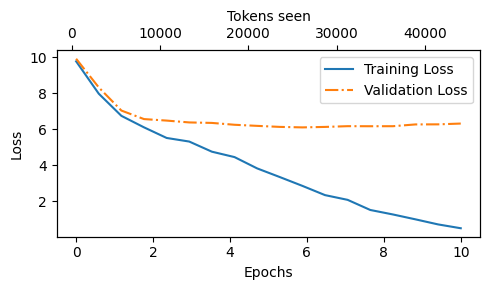

In [40]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    ax1.plot(epochs_seen, train_losses, label='Training Loss')
    ax1.plot(epochs_seen, val_losses, linestyle='-.', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens seen')
    
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 看看上面的结果，我们可以看到，该模型一开始会生成不可理解的字符串，而到最后，它能够生成语法上或多或少正确的句子
- 然而，基于训练和验证集的损失，我们可以看到模型开始过拟合
- 如果我们检查它最后写的几段话，我们会发现它们逐字逐句地包含在训练集中——它只是记住了训练数据
- 稍后，我们将介绍可以在一定程度上减轻这种记忆的解码策略
- 注意，这里出现过拟合是因为我们有一个非常非常小的训练集，并且我们对它迭代了很多次
    - 这里的LLM培训主要用于教育目的；我们主要希望看到模型能够学习生成连贯的文本
    - 我们没有花费数周或数月的时间在大量昂贵的硬件上训练这个模型，而是稍后加载预训练的权重

![Alt text](../../../img/LLM/ch04/train_function_of_LLM.png)

- 如果您有兴趣使用更先进的技术来增强此训练函数，如学习率预热、余弦退火和梯度裁剪，请参阅附录D

- 如果您对更大的训练数据集和更长的训练跑感兴趣，请参阅/03_bonus_preataining_on_gutenberg

# 3 控制随机性的解码策略

- 推理相对便宜，LLM相对较小，作为我们上面训练的GPT模型，因此没有必要使用GPU来进行推理，以防您使用GPU来训练它
- 使用我们前面在简单训练函数中使用的generate_text_simple函数（来自上一章），我们可以一次生成一个单词（或标记）的新文本
- 下一个生成的token对应于词汇表中所有token中最大概率得分的token

In [41]:
model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"


- 即使我们多次执行上面的generate_text_simple函数，LLM也将始终生成相同的输出
- 现在，我们引入两个概念，即所谓的decode策略，来修改generate_text_simple：temperature缩放和top-k采样
- 这些将允许模型控制生成文本的随机性和多样性

## 3.1 temperature缩放

- 以前，我们总是使用torch.argmax对具有最高概率的token进行采样，作为下一个token
- 为了增加多样性，我们可以使用torch.multinomial(probs，num_samples=1)对下一个token进行采样，从概率分布中采样
- 这里，每个索引被选中的几率对应于其在输入张量中的概率
- 以下是生成下一个token的简要回顾，假设用于说明的词汇非常少：

In [42]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [43]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()

print(inverse_vocab[next_token_id])

toward


In [44]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- 我们不是通过torch.argmax来确定最可能的token，而是使用torch.multinomial(probas，num_samples=1)通过从softmax分布中采样来确定最有可能的token
- 为了便于说明，让我们看看当我们使用原始softmax概率对下一个token采样1000次时会发生什么：
- 我们可以通过一个称为 temperature缩放 的概念来控制分布和选择过程
- temperature缩放 只是一个花哨的词，用来将logits除以大于0的数字
- 在应用softmax后，温度大于1将导致更均匀分布的token概率
- 应用softmax后，小于1的温度将导致更可靠（更尖锐或更峰值）的分布

In [45]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

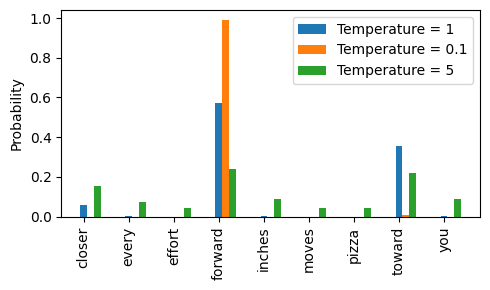

In [46]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 我们可以看到，通过温度0.1的重新缩放导致更尖锐的分布，接近torch.argmax，因此几乎总是选择最有可能的单词

In [47]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [48]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


- 假设LLM输入“every effort moves you”，使用上述方法有时会导致无意义的文本，例如“every effort moves you pizza”，4.3%的时间（1000次中有43次）

## 3.2 Top-k 采样

- 为了能够使用更高的temperature来增加输出多样性并降低无意义句子的概率，我们可以将采样的标记限制为前k个最可能的标记：

![Alt text](../../../img/LLM/ch04/topk_sampling.png)

- (请注意，此图中的数字被截断为小数点后的两位数，以减少视觉混乱。Softmax行中的值加起来应为1.0)
- 在代码中，我们可以实现如下：

In [49]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(f"Top logits:{top_logits}")
print(f"Top positions:{top_pos}")

Top logits:tensor([6.7500, 6.2800, 4.5100])
Top positions:tensor([3, 7, 0])


In [50]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [51]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 3.3 修改文本生成功能

- 前两小节介绍了温度采样和top-k采样
- 让我们使用这两个概念来修改我们之前用于通过LLM生成文本的generate_simple函数，创建一个新的generate函数：

In [52]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
            
        if temperature > 0.0:
            logits = logits / temperature
            
            probs = torch.softmax(logits, dim=-1)
            
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [53]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


# 4 PyTorch中加载和保存模型重量

- 训练LLM的计算成本很高，因此能够保存和加载LLM权重至关重要

![Alt text](../../../img/LLM/ch04/weight_saving.png)

- PyTorch中建议的方法是通过将torch.save函数应用于.state_dict()方法来保存

In [99]:
torch.save(model.state_dict(), 'model.pth')

In [100]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in

- 使用Adam或AdamW等自适应优化器而不是常规SGD来训练LLM是很常见的
- 这些自适应优化器为每个模型权重存储额外的参数，因此，如果我们计划稍后继续预训练，也可以保存这些参数：

In [101]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [102]:
checkpoint = torch.load("model_and_optimizer.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# 5 从OpenAI加载预训练权重

- 以前，我们只使用一本非常小的短篇小说来训练一个小的GPT-2模型，用于教育目的
- 感兴趣的读者还可以在中找到完整的古腾堡项目图书语料库的更长时间的预训练/03_bonus_preataining_on_gutenberg
- 幸运的是，我们不必花费数万至数十万美元在大型预训练语料库上对模型进行预训练，而是可以加载OpenAI提供的预训练权重
- 有关从Hugging Face加载权重的替代方法
- 首先，一些样板代码从OpenAI下载文件并将权重加载到Python中
- 由于OpenAI使用了TensorFlow，我们将不得不安装并使用TensorFlow来加载权重；tqdm是进度条库
- 取消注释并运行下一个单元以安装所需的库

In [54]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.16.1
tqdm version: 4.66.4


In [55]:
from gpt_download import download_and_load_gpt2

- 然后，我们可以下载1.24亿参数模型的模型权重，如下所示：

In [56]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [57]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [58]:
print(f"Parameter dictionary keys:{params.keys()}")

Parameter dictionary keys:dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [59]:
print(params['wte'])
print(f"Token embedding weight tensor dimensions:{params['wte'].shape}")

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions:(50257, 768)


- 除此之外，“355M”、“774M”和“1558M”也支持model_size参数
- 下图总结了这些不同尺寸模型之间的差异：

![Alt text](../../../img/LLM/ch04/model_size.png)

- 综上，我们将124M GPT-2模型权重加载到Python中，但是我们仍然需要将它们转移到我们的GPTModel实例中
- 首先，我们初始化一个新的GPTModel实例
- 请注意，原始GPT模型使用偏差向量初始化了多头注意力模块中查询、键和值矩阵的线性层，这不是必需的或推荐的；然而，为了能够正确地加载权重，我们也必须通过在实现中将qkv_bias设置为True来启用这些权重
- 我们还使用了原始GPT-2模型使用的1024令牌上下文长度

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

- 下一个任务是将OpenAI权重分配给GPTModel实例中相应的权重张量

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_q.weight = assign(
            gpt.transformer_blocks[b].attention.W_q.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_k.weight = assign(
            gpt.transformer_blocks[b].attention.W_k.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_v.weight = assign(
            gpt.transformer_blocks[b].attention.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_q.bias = assign(
            gpt.transformer_blocks[b].attention.W_q.bias, q_b)
        gpt.transformer_blocks[b].attention.W_k.bias = assign(
            gpt.transformer_blocks[b].attention.W_k.bias, k_b)
        gpt.transformer_blocks[b].attention.W_v.bias = assign(
            gpt.transformer_blocks[b].attention.W_v.bias, v_b)

        gpt.transformer_blocks[b].attention.out_proj.weight = assign(
            gpt.transformer_blocks[b].attention.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.out_proj.bias = assign(
            gpt.transformer_blocks[b].attention.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].ffn.layers[0].weight = assign(
            gpt.transformer_blocks[b].ffn.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].ffn.layers[0].bias = assign(
            gpt.transformer_blocks[b].ffn.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].ffn.layers[2].weight = assign(
            gpt.transformer_blocks[b].ffn.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].ffn.layers[2].bias = assign(
            gpt.trf_blocks[b].ffn.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].norm1.scale = assign(
            gpt.transformer_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.shift = assign(
            gpt.transformer_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].norm2.scale = assign(
            gpt.transformer_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.shift = assign(
            gpt.transformer_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用之前的生成函数来生成新文本：

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- 我们知道我们正确地加载了模型权重，因为模型可以生成连贯的文本；即使我们犯了一个小错误，该模式也无法做到这一点
- 有关从Hugging Face加载权重的替代方法